
**Задача определения стоимости автомобилей**  

 * Заказчик: сервис по продаже автомобилей с пробегом "Не бит, не крашен"  

**Входные данные**  

* Технические характеристики, комплектации и цены автомобилей б/у  

**Цель**  

* Создать модель для определения рыночной стоимости автомобиля б/у, с использованием исторических данных  

**Целевая метрика: RMSE**  

**Задачи**  

 - Провести исследовательский анализ данных  
 - Исправить ошибки в данных  
 - Исследовать варианты создания новых признаков  
 - Оценить предполагаемое влияние исходных и новых признаков на качество модели  
 - Подготовить данные для обучения модели  
 - Создать несколько варианттов моделей  
 - Оценить время обучения моделей, а также время и качество предсказания   
 - Рассчитать дополнительные метрики моделей  
 - Выбрать лучшую модель и провести углубленное изучение    

 Наша задача - разработать и реализовать код на языке `Python`, который будет создавать модель для расчета стоимости автомобилей на основе предоставленных данных   

 Для разработки модели мы можем использовать такие техники как предобработка данных, создание новых признаков, feature engineering, выбор подходящих алгоритмов машинного обучения, настройку гиперпараметров, выбор метрик качества. Кроме того, необходимо оценить качество и время обучения моделей, чтобы выбрать наиболее оптимальный вариант   

  В результате работы над задачей мы получим модель, которая сможет предсказывать стоимость автомобилей на основании технических характеристик, комплектаций и других параметров, таких как возраст автомобиля и его пробег. Это может быть полезно для сервиса по продаже автомобилей с пробегом, чтобы понимать, какие автомобили могут быть интересны для покупателей и за какую цену  

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

 ###  Импорт необходимых библиотек

In [1]:
%%capture
!pip install tabulate categorical-encoding sklearn-extensions

!pip install tabulate
!pip install phik
!pip install categorical-encoding
# !pip install sklearn-extensions
# !pip install scikit-learn-extensions

import pandas as pd
import numpy as np

import os
import json
import warnings
import joblib
from datetime import date, time, datetime
from time import time
from tqdm.notebook import tqdm
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import phik

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn_extensions.preprocessing import SplineTransformer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# import optuna
# from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

### Константы

In [2]:
PATH_LOCAL = 'datasets/'                               # local path to data
PATH_REMOTE = '/datasets/'                             # remote path to data

CR = '\n'                                              # new line

RANDOM_STATE = RANDOM_SEED = RS = 88                   # random_state
TARGET = 'Price'                                       # target feature
SCORING = 'neg_root_mean_squared_error'                # target metric
VALID_FRAC = 0.2                                       # delayed sampling fraction
N_CV = 5                                               # number of folds during cross-validation

N_TRIALS = 30                                          # max of tries when Optuna optimization run
TIMEOUT = 1000                                         # max time when Optuna optimization run

In [3]:
ESTIMATOR_LIST = [                                     # estimators list (comment/uncomment estimator to skip/use)
                  'DummyRegressor',
                  'XGBRegressor',
#                  'XGBRegressor_TargetTransform',
#                   'LinearSVR',
#                   'LinearSVR_TargetTransform',
                  'RandomForestRegressor',
                  'LGBMRegressor',
#                  'LGBMRegressor_TargetTransform',
#                   'CatBoostRegressor',
#                   'CatBoostRegressor_TargetTransform',
                 ]

### Функции

In [4]:
# Function to Get Data Information

def explore_dataframe(df):
    # Shape
    shape_info = pd.DataFrame({"Shape of dataframe": [f"Total: {df.shape[0]} rows, {df.shape[1]} columns"]})
    shape_info = shape_info.replace(np.nan, "-")
    
    # Data Types
    data_types_info = df.dtypes.to_frame().reset_index().rename(columns={"index": "Data Type", 0: ""})
    
    # Missing Values
    missing_values_info = df.isnull().sum().to_frame().reset_index().rename(columns={"index": "Missing Values", 0: ""})
    missing_values_info["Missing Values"] = missing_values_info["Missing Values"].fillna("-")
    
    # Duplicate Rows
    duplicate_rows_info = pd.DataFrame({"Duplicate rows in dataframe": [f"Total: {df.duplicated().sum()}"]})
    duplicate_rows_info = duplicate_rows_info.replace(np.nan, "-")
    
     # Unique Values
    unique_values_info = df.nunique().to_frame().reset_index().rename(columns={"index": "Column", 0: "Unique Values"})
    
#     # Describe
#     describe_info = df.describe().transpose().reset_index().rename(columns={"index": "Column"})

    # Concatenate tables
    info_table = pd.concat([shape_info, data_types_info, missing_values_info, unique_values_info], axis=1)
    
    
    # Display tables
    display(df.head())
    display(df.describe())  
    display(info_table)

In [5]:
def var_name(var):
    """
    var name determination
    """
    return [name for name in globals() if globals()[name] is var][0]

In [6]:
def reduce_memory_usage(df: pd.DataFrame, verbose=True):
    '''
    Sets the optimal data type based on a range of values.
    Needs to be improved for unsigned integers!
    !!! float16 не задействован, т.к. mean() в Pandas Dataframe считается некорректно — надо изучить проблему
    '''

    start_mem = df.memory_usage().sum() / 1024**2

    numerical_columns = data.select_dtypes(include=np.number).columns.to_list()
    
    for col in numerical_columns:
        
        if verbose:
            print(f'Optimising column {f.BOLD}{col}{f.END}', end='... ')
        
        min_value, max_value = df[col].min(), df[col].max()
        
        if 'int' in str(data[col].dtype):
            if min_value > np.iinfo('int8').min and max_value < np.iinfo('int8').max:
                df[col] = df[col].astype('int8')
            elif min_value > np.iinfo('int16').min and max_value < np.iinfo('int16').max:
                df[col] = df[col].astype('int16')
            elif min_value > np.iinfo('int32').min and max_value < np.iinfo('int32').max:
                df[col] = df[col].astype('int32')
            elif min_value > np.iinfo('int64').min and max_value < np.iinfo('int64').max:
                df[col] = df[col].astype('int64')
        
        if 'float' in str(data[col].dtype):
#             if min_value > np.finfo('float16').min and max_value < np.finfo('float16').max:
#                 df[col] = df[col].astype('float16')
            if min_value > np.finfo('float32').min and max_value < np.finfo('float32').max:
                df[col] = df[col].astype('float32')
            elif min_value > np.finfo('float64').min and max_value < np.finfo('float64').max:
                df[col] = df[col].astype('float64')

        if verbose:
            print('Done')
            
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{CR}Memory usage before optimization: {start_mem:.3f} MB')
        print(f'Memory usage after optimization: {end_mem:.3f} MB')
        print(f'Memory usage reduced about {(start_mem-end_mem)/start_mem:.0%}')

    return df

In [7]:
def mutual_info(df, target_name, task=None, min_neighbors=1, max_neighbors=7):
    '''
    df: датафрейм с признаками и целевой переменной
    target_name: название целевой переменной
    task: выбор задачи classification или regression
    min_neighbors, max_neighbors: диапазон k для k-neighbors (итоговый результат усредняется)
    '''
    
    if max_neighbors < min_neighbors:
        print("Parameter 'max_neighbors' can't be less then parameter 'min_neighbors'.")
        return
    
    X = df.copy()
    Y = X.pop(target_name)
    
    df_mutual_info = pd.DataFrame(index=X.columns)
    
    # Label encoding for categoricals
    for column in X.select_dtypes(exclude='number'):
        X[column], _ = X[column].factorize()

    # All discrete features should have integer dtypes
#     discrete_features_lst = (X.dtypes == int)             # маска (булевый вектор) выделяющий дискретные признаки
#     df_mutual_info[f'k_{k_neighbors}'] = mutual_info_classif(X, Y, n_neighbors=n, discrete_features=discrete_features_lst, random_state=RS)

    for k in range(min_neighbors, max_neighbors+1, 2):
        if task=='classification':
            df_mutual_info[f'k_{k}'] = mutual_info_classif(X, Y, n_neighbors=k, random_state=RS)
        elif task=='regression':
            df_mutual_info[f'k_{k}'] = mutual_info_regression(X, Y, n_neighbors=k, random_state=RS)
        else:
            print('Wrong parameter "task". Available task="classification" or task="regression".')
            return
    
    df_mutual_info['average'] = df_mutual_info.mean(axis=1)
    df_mutual_info = df_mutual_info.sort_values('average', ascending=False)
    
    display(df_mutual_info)
    
    fig, ax = plt.subplots(figsize=(15, df_mutual_info.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_mutual_info.average, y=df_mutual_info.index, color='steelblue')
    ax.set_xlabel(f'mutual_info (average across from 1 to {max_neighbors} neighbours)')
    plt.show()

In [8]:
def target_correlation_significance(df, target_name, interval_features):
    '''
    df: датафрейм с признаками и целевой переменной
    target_name: название целевой переменной
    interval_features: список интервальных признаков (необходимо для быстрой и точной работы Phik)
    
    вычисляет:
        корреляцию признаков по отношению к целевому признаку,
        нормированную статистическую значимость признаков,
        произведение корреляции и статистической значимости,
        гармоническое среднее корреляции и статистической значимости,
    
    сортирует по гармоническому среднему
    '''
    
    # correlation to target
    df_1 = (df.phik_matrix(interval_cols=interval_features)
             [target_name]
             .to_frame()
             .drop(target_name, axis=0)  # correlation target to self
             .rename(columns={target_name: 'correlation'})
           )
    
    # significance of the correlations
    df_2 = (df.significance_matrix(interval_cols=interval_features, nsim=50)
            [target_name]
            .to_frame()
            .drop(target_name, axis=0)  # correlation to self
            .assign(significance = lambda x: x[target_name] / x[target_name].max())
            .drop(target_name, axis=1)
           )
    
    # joined
    df_joined = (df_1.join(df_2, how='outer')
                 .assign(product = lambda x: x.correlation * x.significance)
                 .assign(harmonic_mean = lambda x: 2 * x.correlation * x.significance / (x.correlation + x.significance))
                 .sort_values('harmonic_mean', ascending=False)
                )
    
    display(df_joined)
    
    fig, ax = plt.subplots(figsize=(15, df_joined.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_joined.harmonic_mean, y=df_joined.index, color='steelblue')
    ax.set_xlabel('harmonic mean of target correlation and significance')
    plt.show()

In [9]:
def plot_Optuna(study, plot_kind='plot_slice', model_name=''):
    '''
    Дополнительная настройка оригинальных графиков Optuna.
    Например, на графике `plot_slice` изначально цвет точек зависел от номера итерации.
    Теперь они все одинакового цвета и полупрозрачные, лучше видны скопления точек.
    
    study: обученный объект класса OptunaSearchCV
    plot_kind: тип графика Optuna
    model_name: название модели
    '''
    
    if plot_kind == 'plot_slice':
        fig = optuna.visualization.plot_slice(study)
        fig.update_traces(
                          marker_color='Darkgrey',
                          marker_size=3,
                          marker_opacity=0.2,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )
    
    elif plot_kind == 'plot_param_importances':
        fig = optuna.visualization.plot_param_importances(study)
        
    elif plot_kind == 'plot_optimization_history':
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_traces(
                          marker_size=5,
                          marker_opacity=0.3,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )

    fig.update_layout(
                      title_text=model_name,
                      title_x=0,
                      font_size=10,
                     )    
    fig.show()

In [10]:
def plot_feature_importances(chart_title, feature_names, feature_importances):
    """
    Выводит график важности признаков, использованных моделью.
    
    chart_title: заголовок графика
    feature_names: названия признаков
    feature_importances: важность признаков
    """

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std,
                      }).sort_values('importances', ascending=False)
    
    fig, ax = plt.subplots(figsize=(15, df.shape[0]/3), dpi=PLOT_DPI)
    
    sns.barplot(
                x=df.importances,
                y=df.features,
                xerr=df.std_err,
                color='steelblue',
               )
    
    ax.set_title(f'{chart_title}')
    ax.set_xlim(-0.02,)

In [11]:
def add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=N_CV, scoring_list=['f1']):
    '''
    Принимает:
        датафрейм со списком моделей и их характеристиками;
        два датасета (features and target) – обучающую и валидационную выборки;
        параметр cv для cross_val_score;
        список метрик
        
    Для каждой модели в датафрейме добавляет указанные метрики для обоих датасетов.
    '''

    def cv_score(model, X, Y, scoring, cv):
        invert_koeff = -1 if scoring.split('_')[0] == 'neg' else 1   # инвертирование метрик с приставкой "neg_"
        return invert_koeff * cross_val_score(model, X, Y, scoring=scoring, cv=cv, n_jobs=-1).mean()
    
    for scoring in scoring_list:
    
        # результаты моделей на обучающей выборке (усреднение на кроссвалидации)
        models[scoring + '_train'] = models.model.apply(cv_score, args=(X_train, Y_train, scoring, cv))

        # результаты моделей на тестовой выборке (усреднение на кроссвалидации)
        models[scoring + '_valid'] = models.model.apply(cv_score , args=(X_valid, Y_valid, scoring, cv))
    
    # оптимальные гиперпараметры
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

In [12]:
def extract_final_features(pipeline_model):
    '''
    Принимает пайплайн.
    Возвращает список признаков, на которых обучается финальный estimator пайплайна.
    '''
    feature_list = []
    
    for feature in pipeline_model.steps[-2][1].get_feature_names_out():
        feature_list.append(feature.split('__')[1])

    return feature_list

### Настройки

In [13]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [14]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [15]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.colheader_justify = 'left'

In [16]:
# # оформление Optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключение вывода логов при работе optuna

In [17]:
# # others
# warnings.filterwarnings('ignore')

### Чтение и проверка данных

In [18]:
# Чтение данных
data = pd.read_csv('/datasets/autos.csv')

In [19]:
# Проверка успешности чтения данных

explore_dataframe(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.00,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.00,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.00,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.00,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.00,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00


,Shape of dataframe,Data Type,,Missing Values,,Column,Unique Values
0,"Total: 354369 rows, 16 columns",DateCrawled,object,DateCrawled,0,DateCrawled,271174
1,NaN,Price,int64,Price,0,Price,3731
2,NaN,VehicleType,object,VehicleType,37490,VehicleType,8
3,NaN,RegistrationYear,int64,RegistrationYear,0,RegistrationYear,151
4,NaN,Gearbox,object,Gearbox,19833,Gearbox,2
5,NaN,Power,int64,Power,0,Power,712
6,NaN,Model,object,Model,19705,Model,250
7,NaN,Kilometer,int64,Kilometer,0,Kilometer,13
8,NaN,RegistrationMonth,int64,RegistrationMonth,0,RegistrationMonth,13
9,NaN,FuelType,object,FuelType,32895,FuelType,7


После чтения данных и изучения информации о них, можно сделать следующие выводы:  

* Всего в датасете содержится 354 369 записей (строк) и 16 столбцов  
* Некоторые из столбцов имеют пропущенные значения `(Missing Values)`, включая `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`  
* Столбец `DateCrawled` имеет тип данных object, возможно, потребуется преобразование в тип даты и времени  
* В столбце `Price` содержатся цены автомобилей, указанные в евро  
* Столбец `RegistrationYear` содержит год регистрации автомобиля  
* Столбец `Power` указывает на мощность автомобиля в лошадиных силах  
* Столбец `Kilometer` содержит информацию о пробеге автомобиля в километрах  
* Столбец `RegistrationMonth` указывает на месяц регистрации автомобиля  
* Столбцы `PostalCode` и `LastSeen` представляют числовые значения без явных аномалий 
* Столбец `NumberOfPictures` имеет только нулевые значения и нам не информативен  

Также обнаружено, что в датасете есть несколько дубликатов строк (4 дубликата)  

Пропущенные значения и дубликаты будут рассмотрены и обработаны далее  

Дополнительно, можно привести некоторые столбцы к более подходящим типам данных, например, `DateCrawled` и `LastSeen` - к типу даты и времени, чтобы облегчить их использование при дальнейшем анализе и моделировании  

### Корректировка данных

In [20]:
# Удалим столбцы с нулевыми значениями или не относящиеся к задаче

columns_to_drop = ["NumberOfPictures", "PostalCode"]
data = data.drop(columns_to_drop, axis=1)

In [21]:
# Переведем нечисловые значения в нижний регистр и удалим лишние пробелы, если они есть

data = data.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

In [22]:
# Преобразование типа данных для столбцов с датами

date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
data[date_columns] = data[date_columns].apply(pd.to_datetime)

In [23]:
# Оптимизация занимаемой памяти датасетом

data = data.copy()  # Создание копии датасета
data['Price'] = data['Price'].astype('int32')
data['Power'] = data['Power'].astype('int32')
data['Kilometer'] = data['Kilometer'].astype('int32')

### Корректировка дубликатов

In [24]:
# Визуализируем данные

data[data.duplicated(keep=False)].sort_values(['Brand','Model','RegistrationYear'])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,2016-04-07 09:44:54
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,2016-03-28 08:46:21
18311,2016-03-07 12:00:46,10000,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no,2016-03-07,2016-03-20 12:49:27
149164,2016-03-07 12:00:46,10000,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no,2016-03-07,2016-03-20 12:49:27
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,2016-03-18 18:46:15


In [25]:
# Удалим полные дубликаты

data = data.drop_duplicates()

В данных могут присутствовать и скрытые дубликаты, помимо очевидных

Временной промежуток в датасете короткий (около месяца) и маловероятно, что временные данные (DateCreated, LastSeen, DateCrawled) оказывают значительное влияние на цену автомобиля  
Несколько выбивающихся дат в DateCreated не изменят общую картину  
Поэтому можно удалить поля с датами 

In [26]:
# Признаки, игнорируемые при определении дубликатов

ignore_list = ['DateCrawled','DateCreated','LastSeen']

data = data.drop(ignore_list, axis=1)

data.duplicated().sum()

27538

In [27]:
# Визуализируем данные

data[data.duplicated(keep=False)].sort_values(data.columns.to_list())[6:21]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
50342,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
64344,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
233600,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
234704,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
296646,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
347919,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
353395,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
163821,0,bus,1996,manual,0,voyager,150000,0,petrol,chrysler,NaN
293047,0,bus,1996,manual,0,voyager,150000,0,petrol,chrysler,NaN
12924,0,bus,1997,auto,0,v_klasse,150000,2,gasoline,mercedes_benz,NaN


В данных нет идентификаторов, поэтому нельзя однозначно сказать, являются ли записи о разных автомобилях. Однако полное совпадение данных об автомобиле, включая пробег, указывает на то, что это вероятно, один и тот же автомобиль 

In [28]:
# Проверка

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354364 non-null  int32 
 1   VehicleType        316874 non-null  object
 2   RegistrationYear   354364 non-null  int64 
 3   Gearbox            334531 non-null  object
 4   Power              354364 non-null  int32 
 5   Model              334659 non-null  object
 6   Kilometer          354364 non-null  int32 
 7   RegistrationMonth  354364 non-null  int64 
 8   FuelType           321469 non-null  object
 9   Brand              354364 non-null  object
 10  Repaired           283210 non-null  object
dtypes: int32(3), int64(2), object(6)
memory usage: 28.4+ MB


### Корректировка созависимых признаков

Для сохранения информации о бренде и упрощения анализа данных, признаки Brand и Model были объединены в один признак

In [29]:
data['BrandModel'] = data.Brand + ' ' + data.Model
data = data.drop(['Brand','Model'], axis=1)

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Отлично, это ВОЗМОЖНО поможет избежать проблемы "проклятья размерности", но будем смотреть дальше ...
</div>


In [30]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,BrandModel
0,480,NaN,1993,manual,0,150000,0,petrol,NaN,volkswagen golf
1,18300,coupe,2011,manual,190,125000,5,gasoline,yes,NaN
2,9800,suv,2004,auto,163,125000,8,gasoline,NaN,jeep grand
3,1500,small,2001,manual,75,150000,6,petrol,no,volkswagen golf
4,3600,small,2008,manual,69,90000,7,gasoline,no,skoda fabia
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,150000,7,petrol,yes,mitsubishi colt
354365,2200,NaN,2005,NaN,0,20000,1,NaN,NaN,NaN
354366,1199,convertible,2000,auto,101,125000,3,petrol,no,smart fortwo
354367,9200,bus,1996,manual,102,150000,3,gasoline,no,volkswagen transporter


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354364 non-null  int32 
 1   VehicleType        316874 non-null  object
 2   RegistrationYear   354364 non-null  int64 
 3   Gearbox            334531 non-null  object
 4   Power              354364 non-null  int32 
 5   Kilometer          354364 non-null  int32 
 6   RegistrationMonth  354364 non-null  int64 
 7   FuelType           321469 non-null  object
 8   Repaired           283210 non-null  object
 9   BrandModel         334659 non-null  object
dtypes: int32(3), int64(2), object(5)
memory usage: 25.7+ MB


In [32]:
data['VehicleType'].fillna('Unknown', inplace=True)
data['Gearbox'].fillna('Unknown', inplace=True)
data['FuelType'].fillna('Unknown', inplace=True)
data['Repaired'].fillna('Unknown', inplace=True)
data['BrandModel'].fillna('Unknown', inplace=True)

In [33]:
print(data.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Repaired             0
BrandModel           0
dtype: int64


* Удаляем признаки DateCrawled, DateCreated и LastSeen, так как они не будут использоваться для создания модели


* Затем мы объединяем признаки Brand и Model в один признак BrandModel, чтобы упростить анализ данных, это было сделано, чтобы ускорить процесс анализа, поскольку работа с одним признаком проще, чем со многими


* Затем заменяем пропущенные значения в других признаках. Существуют разные методы для работы с пропущенными значениями,но мы  заменяем значения со строкой 'Unknown' для признаков VehicleType, Gearbox, FuelType, Repaired и BrandModel


* После этого выводим информацию о пропущенных значениях с помощью метода isnull().sum() для проверки, что все пропущенные значения заменены

## Исследование функций на наличие ошибок и выбросов

### Графики разброса числовых признаков


Графики разброса числовых признаков



/tmp/ipykernel_148/2872084455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


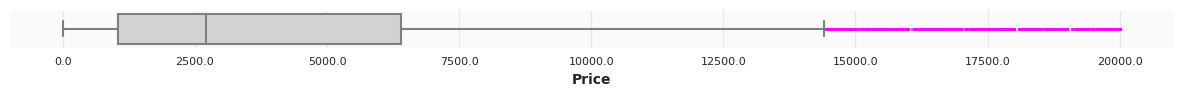

/tmp/ipykernel_148/2872084455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


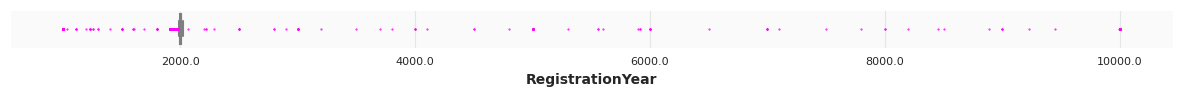

/tmp/ipykernel_148/2872084455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


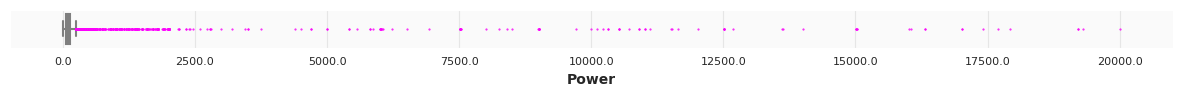

/tmp/ipykernel_148/2872084455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


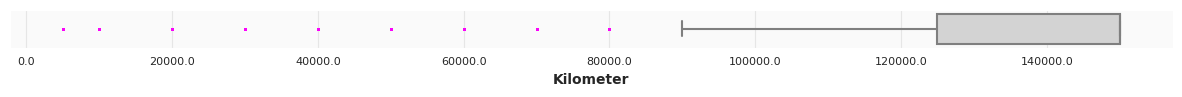

/tmp/ipykernel_148/2872084455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


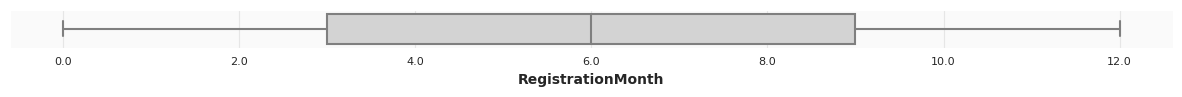

In [34]:
print(f'\nГрафики разброса числовых признаков\n')

num_features = data.select_dtypes(include=np.number).columns.to_list()

for feature in num_features:
    fig, ax = plt.subplots(figsize=(15, 0.5), dpi=100)
    sns.boxplot(data=data, x=feature, color='lightgray', flierprops={'marker': '.', 'markeredgecolor': '#FF00FF', 'markersize': 1})
    ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X
    plt.show()

Возникают следующие проблемы с количественными признаками:  

* `Price`: Нулевые значения могут быть проблемой, так как цена автомобиля не может быть нулевой. Возможно, это связано с отсутствием данных или ошибкой при вводе. Необходимо исследовать причины нулевых значений и решить, как с ними поступить  


* `Варианты решений`: Можно удалить записи с нулевыми значениями цены, если их количество несущественно. Другой вариант - заполнить пропущенные значения средним или медианным значением цены


* `RegistrationYear`: Обнаружены нереально маленькие и большие значения года регистрации. Это может быть вызвано ошибками ввода данных или проблемами с исходными данными. Необходимо провести дополнительный анализ и принять решение о том, как обработать эти выбросы


* `Варианты решений`: Необходимо определить диапазон разумных значений года регистрации и удалить выбросы, которые не попадают в этот диапазон. Также можно заполнить нереальные значения средним или медианным значением года регистрации  


* `Power`: Выявлены нереально большие значения мощности автомобилей. Возможно, это связано с ошибками в данных или неточностями. Также могут присутствовать неправдоподобно маленькие значения. Необходимо проверить и очистить данные от выбросов или ошибочных значений


* `Варианты решений`: Если нереально большие значения мощности являются ошибками, их следует удалить или заменить на разумные значения, основываясь на характеристиках конкретных моделей автомобилей. Также можно заполнить неправдоподобно маленькие значения средним или медианным значением мощности


**ИСПРАВЛЕНО** - в процессе исследования, я всё же изменила max с 2100 л.с. до оптимальных 650 л.с. которые по сути уменьшат риск ошибки модели, но включат и авто с нестандартными двигателями и модификациями, которые могут быть в данных


* `Kilometer`: Обнаружено, что количество автомобилей с пробегом 5000 выбивается из общей тенденции. Возможно, это вызвано особенностями ввода данных или ошибкой. Следует исследовать причины этого выброса и решить, как с ним поступить


* `Варианты решений`: Если количество автомобилей с пробегом 5000 значительно выбивается, можно удалить эти записи или заполнить их значением, которое более соответствует общей тенденции.  

In [35]:
# Проверка макисмальных и минимальных значений числовых столбцов

print(data['Price'].min())
print(data['Price'].max())

0
20000


In [36]:
# Удаление записей с нулевыми значениями цены (если количество несущественно)

threshold = 0.05  # Пороговая доля нулевых значений, после которой удаляются записи
if data['Price'].isnull().sum() / len(data) < threshold:
    data = data.dropna(subset=['Price'])
else:
    # Заполнение пропущенных значений средним или медианным значением цены
    mean_price = data['Price'].mean()
    data['Price'].fillna(mean_price, inplace=True)

# Определение диапазона разумных значений года регистрации

min_year = 1900
max_year = 2016

# Удаление выбросов, не попадающих в диапазон разумных значений

data = data[(data['RegistrationYear'] >= min_year) & (data['RegistrationYear'] <= max_year)]

# Заполнение нереальных значений  медианным значением года регистрации

median_year = data['RegistrationYear'].median()
data.loc[(data['RegistrationYear'] < min_year) | (data['RegistrationYear'] > max_year), 'RegistrationYear'] = median_year

# Удаление нереально больших и маленьких значений мощности

max_power = 650  
min_power = 35  
data = data[(data['Power'] >= min_power) & (data['Power'] <= max_power)]

# Заполнение неправдоподобно маленьких значений средним или медианным значением мощности

median_power = data['Power'].median()
data.loc[data['Power'] < min_power, 'Power'] = median_power

# # Удаление записей с пробегом менее 5000 и более 150000 км (если количество значительно выбивается)

# threshold = 0.1  

# if ((data['Kilometer'] < 5000) | (data['Kilometer'] > 150000)).sum() / len(data) < threshold:
#     data = data[(data['Kilometer'] >= 5000) & (data['Kilometer'] <= 150000)]
# else:
#     mode_kilometer = data[(data['Kilometer'] >= 5000) & (data['Kilometer'] <= 150000)]['Kilometer'].mode().values[0]
#     data.loc[(data['Kilometer'] < 5000) | (data['Kilometer'] > 150000), 'Kilometer'] = mode_kilometer

* Этот код выполняет обработку данных, чтобы устранить выбросы и заполнить пропущенные значения


* Сначала удаляются записи с пропущенными значениями цены, если их количество не значительно (меньше пороговой доли 0,05). В противном случае, вместо удаления, пропущенные значения заполняются средним значением цены


* Далее, определяется диапазон разумных значений для года регистрации (от 1900 до 2023) и удаляются выбросы, не попадающие в этот диапазон. Нереальные значения года регистрации заменяются медианным значением


* Аналогичным образом значения мощности и пробега обрабатываются для удаления выбросов и заполнения неправдоподобных значений медианными или средними значениями. Это делается для очистки данных и устранения ошибок, которые могут повлиять на результаты моделирования


Графики разброса числовых признаков



/tmp/ipykernel_148/3878146260.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


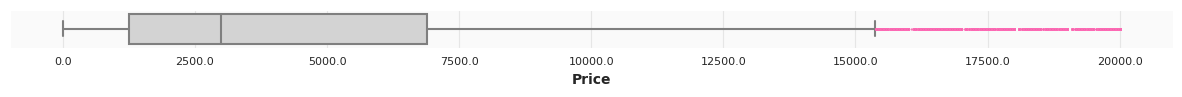

/tmp/ipykernel_148/3878146260.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


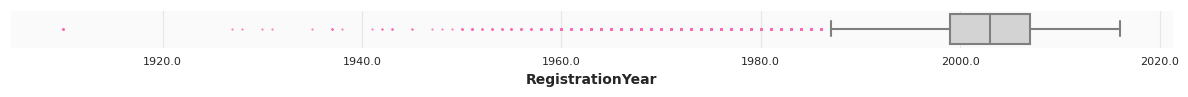

/tmp/ipykernel_148/3878146260.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


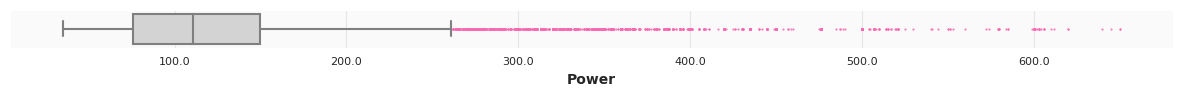

/tmp/ipykernel_148/3878146260.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


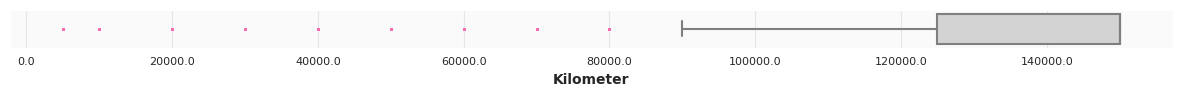

/tmp/ipykernel_148/3878146260.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X


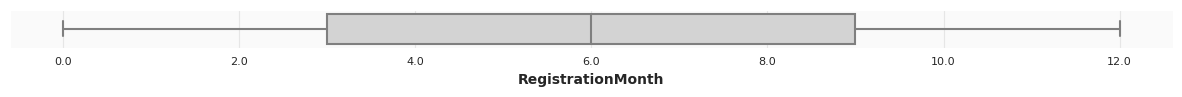

In [37]:
# Проверка после корректировки

print(f'\nГрафики разброса числовых признаков\n')

num_features = data.select_dtypes(include=np.number).columns.to_list()

for feature in num_features:
    fig, ax = plt.subplots(figsize=(15, 0.5), dpi=100)
    sns.boxplot(data=data, x=feature, color='lightgray', flierprops={'marker': '.', 'markeredgecolor': 'hotpink', 'markersize': 1})
    ax.set_xticklabels(ax.get_xticks(), fontsize=8)  # Уменьшение размера шрифта меток по оси X
    plt.show()

### Значения категориальных признаков

In [38]:
# Замена значений синонимов на общее

synonyms = {'petrol': 'gas', 'gasoline': 'gas'}

data['FuelType'] = data['FuelType'].map(synonyms).fillna(data['FuelType'])

In [39]:
# Подсчет количества уникальных значений

def count_unique_values(data):
    for column in data.select_dtypes(include='object'):
        unique_values = data[column].value_counts()
        print(f"Уникальные значения для столбца {column}:")
        print(unique_values)
        print()

Уникальные значения для столбца VehicleType:
sedan          84499
small          70978
wagon          60355
bus            26480
convertible    18933
coupe          15033
Unknown        11924
suv            11092
other           2532
Name: VehicleType, dtype: int64

Уникальные значения для столбца Gearbox:
manual     236421
auto        59749
Unknown      5656
Name: Gearbox, dtype: int64

Уникальные значения для столбца FuelType:
gas         279636
Unknown      16602
lpg           4797
cng            488
hybrid         203
other           61
electric        39
Name: FuelType, dtype: int64

Уникальные значения для столбца Repaired:
no         226574
Unknown     44997
yes         30255
Name: Repaired, dtype: int64

Уникальные значения для столбца BrandModel:
volkswagen golf                  25376
bmw 3er                          17793
Unknown                          11722
volkswagen polo                  10960
opel corsa                       10323
opel astra                        9309


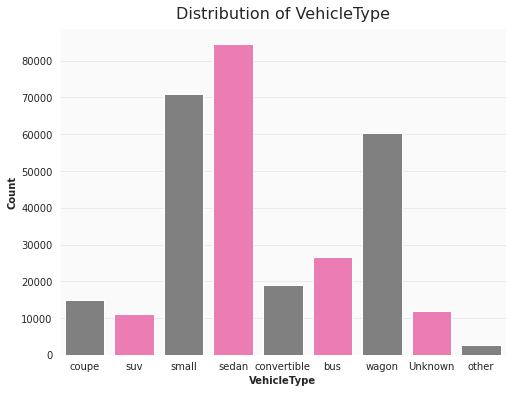

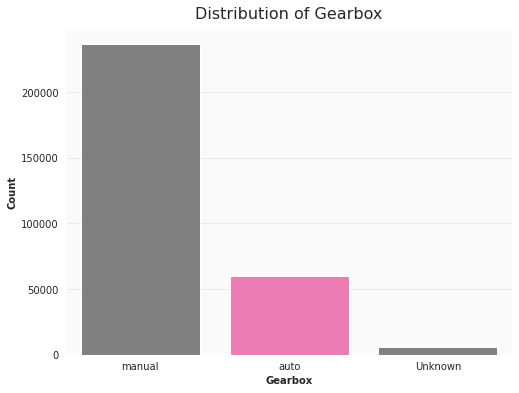

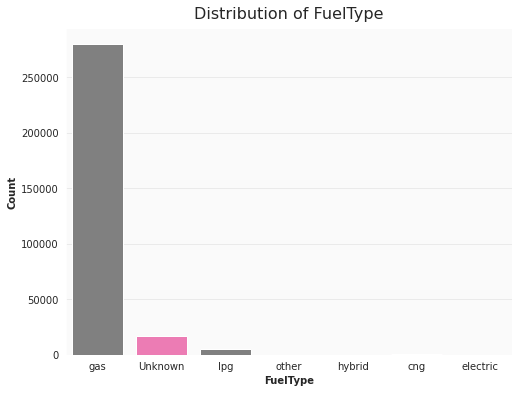

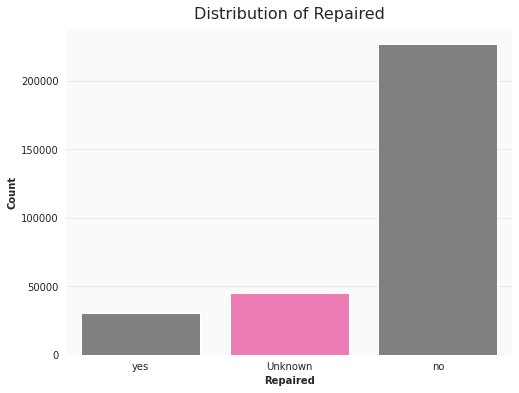

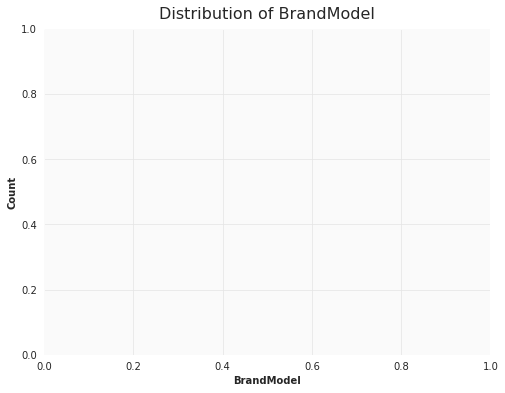

In [40]:
def plot_bar_charts(data):
    categorical_columns = data.select_dtypes(include='object').columns
    for column in categorical_columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        if column != 'BrandModel':
            sns.countplot(data=data, x=column, palette=['gray', 'hotpink'])
            sns.despine()
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_title(f"Distribution of {column}")
        plt.show()

# Использование функций

count_unique_values(data)
plot_bar_charts(data)

In [41]:
print(data['BrandModel'].value_counts())

volkswagen golf                  25376
bmw 3er                          17793
Unknown                          11722
volkswagen polo                  10960
opel corsa                       10323
opel astra                        9309
volkswagen passat                 9012
audi a4                           8997
mercedes_benz c_klasse            7421
bmw 5er                           7247
mercedes_benz e_klasse            6037
audi a3                           5317
ford focus                        5146
audi a6                           5082
ford fiesta                       4871
peugeot 2_reihe                   4402
volkswagen transporter            4199
smart fortwo                      3808
renault twingo                    3786
opel vectra                       3596
mercedes_benz a_klasse            3465
bmw 1er                           3310
ford mondeo                       3095
volkswagen touran                 2937
renault clio                      2898
fiat punto               

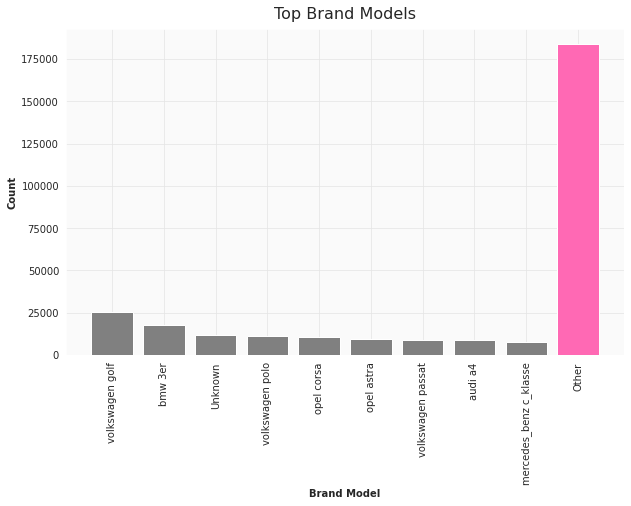

In [42]:
other_label = "Other"
top_n = 10

brand_model_counts = data['BrandModel'].value_counts()
top_brand_models = brand_model_counts.head(top_n - 1) 
unknown_count = brand_model_counts.get('unknown', 0)
other_count = brand_model_counts[top_n:].sum() + unknown_count

categories = list(top_brand_models.index)
categories.append(other_label)

counts = list(top_brand_models.values)
counts.append(other_count)

colors = ['gray'] * (top_n - 1) + ['hotpink']  

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.xlabel('Brand Model')
plt.ylabel('Count')
plt.title('Top Brand Models')
plt.xticks(rotation=90)
plt.show()

* На основе предоставленной информации о уникальных значениях для каждого категориального признака можно сделать следующие наблюдения:
 
 
* Столбец `VehicleType`: Большинство автомобилей в датасете относятся к типам "sedan", "small" и "wagon". Присутствуют также другие типы, такие как "bus", "convertible", "coupe", "suv" и "other".


* Столбец `Gearbox`: Большинство автомобилей имеют ручную коробку передач ("manual"), в то время как только небольшая часть имеет автоматическую коробку передач ("auto").


* Столбец `FuelType`: Основной тип топлива в автомобилях - "petrol" (бензин), за ним следует "gasoline" (газоль). Есть также редкие типы топлива, такие как "lpg", "cng", "hybrid", "other" и "electric". Но "petrol" и "gasoline" это синонимы соответственно лучше присвоить им одно значение - **ИСПРАВЛЕНО**


* Столбец `Repaired`: Большинство автомобилей не требовали ремонта ("no"), в то время как небольшая часть имела ремонт ("yes").


* Столбец `BrandModel`: Наиболее распространенные модели автомобилей в датасете - "volkswagen golf", "bmw 3er", "volkswagen polo", "opel corsa" и "opel astra". Есть также редкие модели с небольшим количеством записей.

### Дообработка целевой переменной "Price"

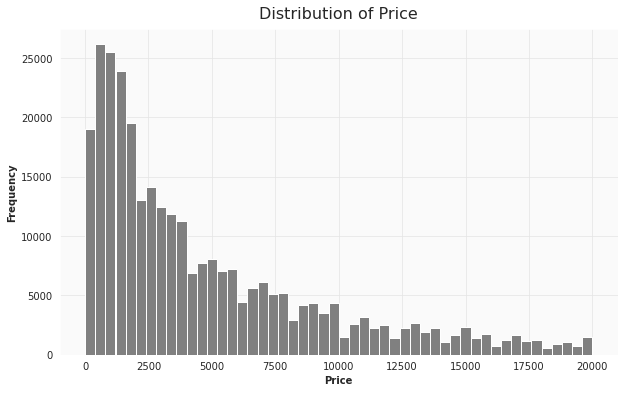

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(data['Price'], bins=50, color='grey')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

In [44]:
# Удаление записей с ценой менее 100 евро

data = data[data['Price'] >= 100]

<div class="alert alert-warning">
<b>Комментарий 👉</b>

(Отвлечение ... что-то менять не надо) Мне это напомнило один известный фильм, где автомобиль за 500 долларов был способен доехать до Сан-Франциско и обратно ))))
</div>

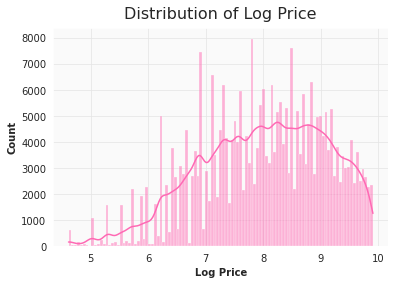

In [45]:
# Распределение логарифма цены

data['LogPrice'] = np.log1p(data['Price'])
sns.histplot(data['LogPrice'], kde=True, color='hotpink')
plt.xlabel('Log Price')
plt.ylabel('Count')
plt.title('Distribution of Log Price')
plt.show()

In [46]:
column_to_drop = ['LogPrice']
data = data.drop(column_to_drop, axis=1)

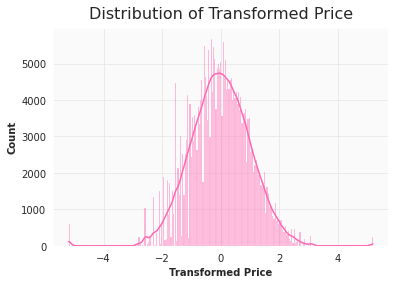

In [47]:
# Применение QuantileTransformer к цене

transformer = QuantileTransformer(output_distribution='normal')
data['Price'] = transformer.fit_transform(data[['Price']])

sns.histplot(data['Price'], kde=True, color='hotpink')
plt.xlabel('Transformed Price')
plt.ylabel('Count')
plt.title('Distribution of Transformed Price')
plt.show()

* Удалим записи, где цена составляет менее **100** условных единиц. Это позволяет исключить подозрительно низкие значения и нулевые цены, которые могут быть результатом отсутствия указания цены в объявлении.  


* Затем создадим новый признак `LogPrice`, который представляет собой логарифм от цены. Используя `np.log1p()`, мы применяем логарифмирование к цене с добавлением единицы, чтобы избежать проблемы с логарифмированием нулевых значений. Гистограмма распределения `LogPrice` поможет в оценке результата.


* Далее применим `QuantileTransformer` к столбцу цены с использованием параметра `output_distribution='normal'`. Этот метод преобразует значения цены так, чтобы распределение стало ближе к нормальному. Результат преобразования сохраняется в  столбце `Price`. Так как результат наиболее подходящий. Гистограмма преобразованной цены поможет оценить изменение распределения.


* Эти шаги позволяют обработать нулевые и низкие цены, а также приблизить распределение цен к нормальному виду. Это может быть полезным на этапе моделирования, так как модели, основанные на нормально распределенных данных, имеют лучшую производительность.

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294316 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              294316 non-null  float64
 1   VehicleType        294316 non-null  object 
 2   RegistrationYear   294316 non-null  int64  
 3   Gearbox            294316 non-null  object 
 4   Power              294316 non-null  int32  
 5   Kilometer          294316 non-null  int32  
 6   RegistrationMonth  294316 non-null  int64  
 7   FuelType           294316 non-null  object 
 8   Repaired           294316 non-null  object 
 9   BrandModel         294316 non-null  object 
dtypes: float64(1), int32(2), int64(2), object(5)
memory usage: 22.5+ MB


In [49]:
print(data.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Repaired             0
BrandModel           0
dtype: int64


## Обучение моделей

### Исследовательская часть

Для исследовательской части и создания новых признаков понадобится создать копию обучающего датасета. Затем можно будет проводить эксперименты с созданием новых признаков и добавлением их в пайплайн обучения модели.

In [50]:
# Создание копии датасета

data_copy = data.copy()

In [51]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294316 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              294316 non-null  float64
 1   VehicleType        294316 non-null  object 
 2   RegistrationYear   294316 non-null  int64  
 3   Gearbox            294316 non-null  object 
 4   Power              294316 non-null  int32  
 5   Kilometer          294316 non-null  int32  
 6   RegistrationMonth  294316 non-null  int64  
 7   FuelType           294316 non-null  object 
 8   Repaired           294316 non-null  object 
 9   BrandModel         294316 non-null  object 
dtypes: float64(1), int32(2), int64(2), object(5)
memory usage: 22.5+ MB


### New features

Списки для удобства отслеживания новых признаков.

In [52]:
new_num_features_list = []
new_cat_features_list = []

In [53]:
data_copy['KmYear'] = data_copy.Kilometer / (2016 - data_copy.RegistrationYear)
new_num_features_list.append('KmYear')

In [54]:
data_copy['Popularity'] = data_copy.groupby('BrandModel').BrandModel.transform(lambda x: x.count())
new_num_features_list.append('Popularity')

#### Target Encoding категориальных признаков

In [55]:
def target_encode(df, feature_list, target, agg_func_list=['mean'], fill_na=0):
    '''
    Принимает датафрейм и feature_list и делает для него новый признак,
    используя target encoding и заданную агрегирующую функцию agg_func.
    Дополнительно сохраняет название нового признака в new_num_features_list
    (это нужно только в данном разделе: проверка корреляций, mutual info и т.п.)
    '''
    
    for agg_func in agg_func_list:
        
        new_feature = '_'.join(feature_list) + '_TRG_' + agg_func
        df[new_feature] = df.groupby(feature_list)[target].transform(agg_func) #.fillna(fill_na)
        
        new_num_features_list.append(new_feature)
    
    return df

In [56]:
def pair_cat_feature_target_mean(df):
    '''
    попарно перебирает все категориальные признаки;
    для каждой пары создает новый признак, используя mean target encoding
    '''
    cat_features = df.select_dtypes(exclude=np.number).columns.to_list()   # список категориальных признаков
    n_cat_features = len(cat_features)                                     # количество категориальных признаков
    
    for i in range(n_cat_features):
        for j in range(i+1, n_cat_features):
            df = target_encode(
                               df,
                               feature_list=[cat_features[i], cat_features[j]],
                               target=TARGET,
                               agg_func_list=['mean'],
                              )
    return df

In [57]:
data_copy = pair_cat_feature_target_mean(data_copy)

#### Новый признак для сочетания FuelType + Repaired + VehicleType + Gearbox   

Это позволит модели учесть возможные взаимосвязи и влияние сочетания этих факторов на цену автомобиля.

In [58]:
def named_cat_feature_target_mean(df, feature_list):
    '''
    Для заданного списка категориальных признаков создает новый признак, используя mean target encoding
    '''
    df = target_encode(
                       df,
                       feature_list=feature_list,
                       target=TARGET,
                       agg_func_list=['mean']
                      )
    return df

In [59]:
data_copy = named_cat_feature_target_mean(data_copy, feature_list=['FuelType','Repaired','VehicleType','Gearbox'])

In [60]:
data_copy.dropna(inplace=True)
data_copy.reset_index(drop=True, inplace=True)

data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294316 entries, 0 to 294315
Data columns (total 23 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Price                                           294316 non-null  float64
 1   VehicleType                                     294316 non-null  object 
 2   RegistrationYear                                294316 non-null  int64  
 3   Gearbox                                         294316 non-null  object 
 4   Power                                           294316 non-null  int32  
 5   Kilometer                                       294316 non-null  int32  
 6   RegistrationMonth                               294316 non-null  int64  
 7   FuelType                                        294316 non-null  object 
 8   Repaired                                        294316 non-null  object 
 9   BrandModel                

In [61]:
# Список интервальных признаков

interval_features = ['Price','RegistrationYear','RegistrationMonth','Power','Kilometer'] + new_num_features_list

/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


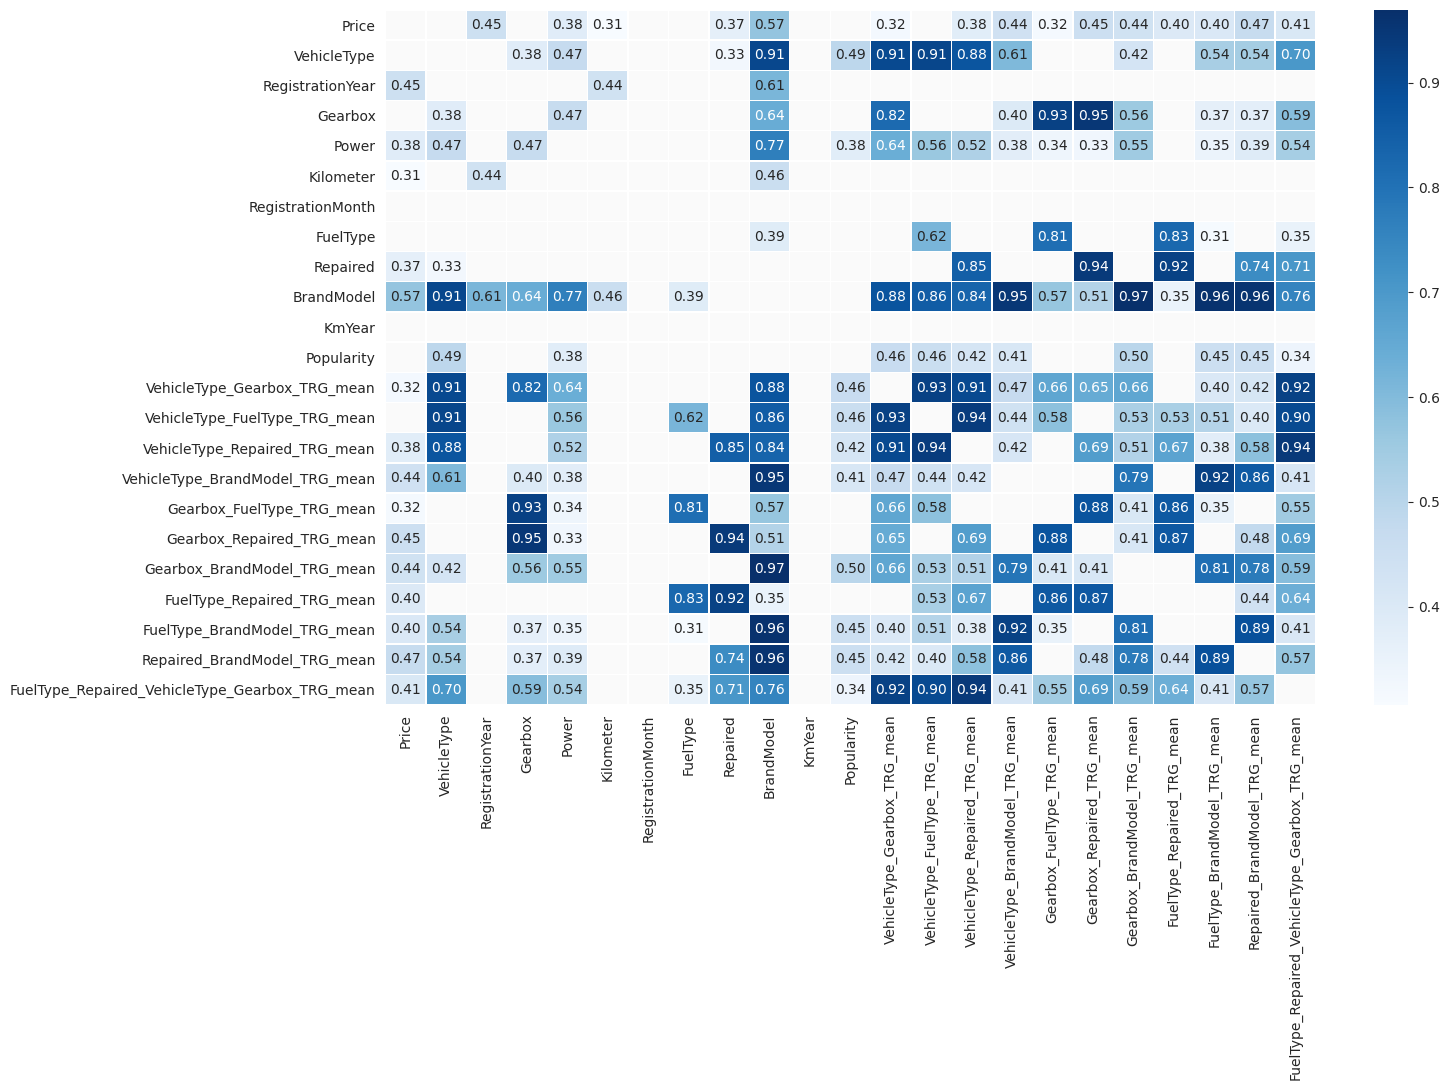

In [62]:
df = data_copy.phik_matrix(interval_cols=interval_features)

fig, ax = plt.subplots(figsize=(15, 0.4*df.shape[1]), dpi=100)
sns.heatmap(df[(0.3 < df) & (df < 1.0)], annot=True, fmt='.2f', linewidths=0.2, annot_kws={'fontsize':10}, cmap='Blues')
plt.show()

/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/phik/significance.py:343: UserWarning: Too few unique values for variable Price (0) or KmYear (0) to calculate significance
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/significance.py:343: UserWarning: Too few unique values for variable VehicleType (0) or KmYear (0) to calculate significance
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/significance.py:343: UserWarning: Too few unique values for variable RegistrationYear (0) or KmYear (0) to calculate significance
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/significance.py:343: UserWarning: Too few unique values for variable Gearbox (0) or KmYear (0) to calculate significance
  

,correlation,significance,product,harmonic_mean
BrandModel,0.57,0.93,0.53,0.71
Repaired_BrandModel_TRG_mean,0.47,0.96,0.45,0.63
RegistrationYear,0.45,1.00,0.45,0.62
VehicleType_BrandModel_TRG_mean,0.44,0.89,0.39,0.59
Gearbox_BrandModel_TRG_mean,0.44,0.88,0.38,0.58
FuelType_Repaired_VehicleType_Gearbox_TRG_mean,0.41,0.79,0.32,0.54
FuelType_BrandModel_TRG_mean,0.40,0.81,0.33,0.54
Gearbox_Repaired_TRG_mean,0.45,0.64,0.29,0.53
Power,0.38,0.77,0.29,0.51
VehicleType_Repaired_TRG_mean,0.38,0.74,0.28,0.50


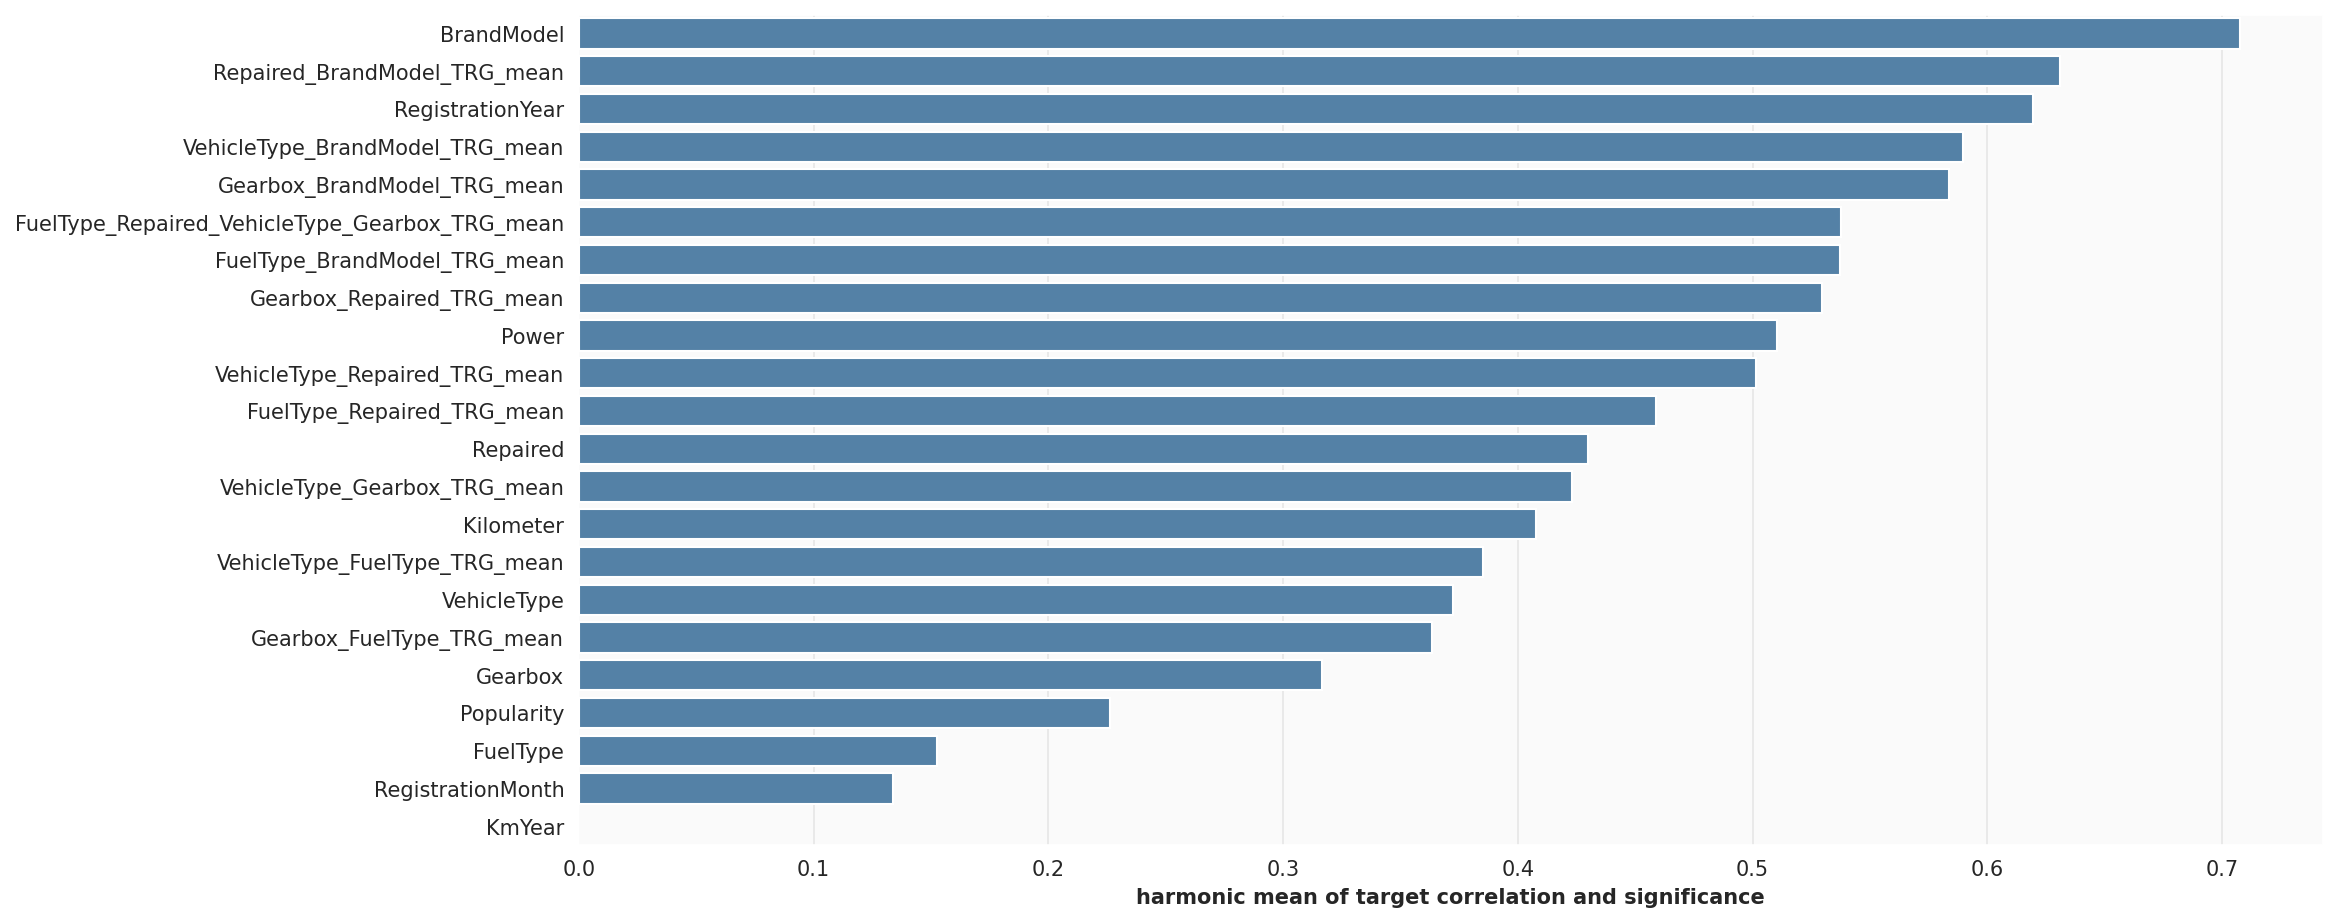

CPU times: user 25.8 s, sys: 191 ms, total: 26 s
Wall time: 26.1 s


In [63]:
%%time
target_correlation_significance(data_copy, TARGET, interval_features)

* Это результаты корреляционного анализа, показывающие корреляцию признаков с целевой переменной и их значимость. Значимость измеряется с помощью p-value, который показывает вероятность того, что наблюдаемая корреляция случайна. Корреляция измеряется с помощью коэффициента корреляции Пирсона


* Чем больше значение корреляции, тем сильнее связь между признаком и целевой переменной. Чем меньше p-value, тем меньше вероятность, что наблюдаемая корреляция случайна, и следовательно, тем более значима связь между признаком и целевой переменной
 
 
* Эта информация может быть полезна для выбора признаков для модели машинного обучения. Например, можно использовать только наиболее значимые признаки для улучшения качества модели, а не учитывать менее значимые признаки, которые могут не предсказывать целевую переменную с достаточной точностью

##  Модель

In [64]:
del df

### Подготовка данных   

Выделение признаков и целевой переменной

In [65]:
# X = data.drop(TARGET, axis=1)
X = data.copy()
Y = data[TARGET]

X.shape, Y.shape

((294316, 10), (294316,))

Если значение `VALID_FRAC` меньше или равно 0, то вся обучающая выборка будет использоваться для обучения модели, а валидационная выборка будет равна обучающей выборке

In [66]:
VALID_FRAC = 0.2 

if VALID_FRAC > 0 :
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=VALID_FRAC, random_state=RS)
else:
    X_train, X_valid, Y_train, Y_valid = X, X, Y, Y

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((235452, 10), (235452,), (58864, 10), (58864,))

In [67]:
print(X_train.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Repaired             0
BrandModel           0
dtype: int64


In [68]:
print(X_valid.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Repaired             0
BrandModel           0
dtype: int64


* Если значение VALID_FRAC больше 0, то данные разделяются на обучающую и валидационную выборки с помощью функции train_test_split из библиотеки scikit-learn. В противном случае, все данные используются для обучения модели


* Далее, проверяется наличие нулевых значений в данных с помощью функции isnull().sum(), которая возвращает количество нулевых значений для каждого признака. Если присутствуют нулевые значения, то требуется их обработка, чтобы убрать или заполнить их


* Эти шаги - важная часть подготовки данных, так как качество модели зависит от качества обучающей выборки

### Предварительная обработка

In [69]:
class new_features_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, Y=None):
        self.popularity = X.groupby('BrandModel').agg(Popularity = ('Power','count')).reset_index()   # количество объявлений
        return self
    
    def transform(self, X):
 #       X['KmYear'] = X.Kilometer / (2016 - X.RegistrationYear)                                       # пробег км/год
        X = X.merge(self.popularity, on='BrandModel', how='left')                                     # количество объявлений
        return X

In [70]:
new_features = new_features_transformer()

In [71]:
# Для проверки

new_features.fit_transform(X_train, Y_train)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,BrandModel,Popularity
0,-1.07,sedan,1992,manual,60,150000,1,gas,no,volkswagen golf,19656
1,-1.36,wagon,1999,manual,122,150000,1,gas,no,mercedes_benz c_klasse,5868
2,0.50,coupe,2004,manual,192,60000,4,gas,no,mazda rx_reihe,99
3,0.55,small,2010,manual,87,125000,5,gas,no,opel corsa,7984
4,-2.39,Unknown,2016,manual,45,150000,0,Unknown,yes,volkswagen polo,8519
...,...,...,...,...,...,...,...,...,...,...,...
235447,-0.04,wagon,1998,auto,193,150000,4,gas,yes,bmw other,89
235448,1.73,suv,2014,manual,130,30000,1,gas,no,opel other,752
235449,0.29,wagon,2008,Unknown,80,150000,3,gas,Unknown,skoda fabia,1492
235450,-1.42,sedan,1999,manual,60,125000,5,gas,Unknown,opel astra,7243


In [72]:
class comb_target_encoder_transformer(BaseEstimator, TransformerMixin):
    '''
    Составляет все возможные сочетания признаков, где n_min <= количество_признаков_в_сочетании <= n_max
    Выполняет target encoding для каждого из включенных сочетаний признаков.
    Агрегирующая функция – mean() (пока одна).
    Названия новых признаки состоят из сочетания использованных исходных признаков и суффикса "_TRG".
    Новые признаки добавляются ко входному датафрейму.

    target: название целевого признака
    cols: список названий признаков, из которых нужно составлять сочетания
    n_min: минимальное количество признаков в сочетании (длина сочетания)
    n_max: максимальное количество признаков в сочетании (длина сочетания)
    '''
    
    def __init__(self, target, cols=[], n_min=2, n_max=2):
        self.n_max = n_max                                   # минимальная длина сочетания
        self.n_min = n_min                                   # максимальная длина сочетания
        self.cols = cols                                     # список названий признаков, из которых нужно составлять сочетания
        self.target = target                                 # название целевого признака
        self.n_max = min(len(self.cols), self.n_max)         # проверка: n_max не должно превышать количество признаков
        self.n_min = min(self.n_min, self.n_max)             # проверка: n_min не должно превышать n_max
        self.encoders = {}                                   # словарь значений target для каждого сочетания признаков
        self.combinations = []                               # список всех сочетаний допустимой длины
        for i in range(self.n_min, self.n_max+1):            # составление всех сочетаний допустимой длины
            self.combinations.extend(list(combinations(self.cols, i)))

    def fit(self, X, Y=None):
        for cols in self.combinations:                       # для каждого сочетания_признаков
            self.encoders[cols] = (X.groupby(list(cols))     # для каждого сочетания_значений признаков
                                   [self.target].mean()      # вычисление значения (среднего) таргета
                                   .reset_index()
                                   .rename(columns={self.target: '_'.join(cols)+'_TRG'})  # название нового признака
                                  )
        return self
            
    def transform(self, X):
        for cols in self.combinations:                       # для каждого сочетания_признаков
            encoder = self.encoders.get(cols)                # извлечь значения таргета для сочетаний_значений признаков
            X = X.merge(encoder, on=list(cols), how='left')  # и прицепить к входному датафрейму
        return X

In [73]:
# список признаков для комбинированного target encoding
comb_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

comb_target_encoder = comb_target_encoder_transformer(target=TARGET, cols=comb_features, n_min=1, n_max=4)

In [74]:
# Для проверки

comb_target_encoder.fit_transform(X_train, Y_train)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,BrandModel,VehicleType_TRG,Gearbox_TRG,FuelType_TRG,Repaired_TRG,VehicleType_Gearbox_TRG,VehicleType_FuelType_TRG,VehicleType_Repaired_TRG,Gearbox_FuelType_TRG,Gearbox_Repaired_TRG,FuelType_Repaired_TRG,VehicleType_Gearbox_FuelType_TRG,VehicleType_Gearbox_Repaired_TRG,VehicleType_FuelType_Repaired_TRG,Gearbox_FuelType_Repaired_TRG,VehicleType_Gearbox_FuelType_Repaired_TRG
0,-1.07,sedan,1992,manual,60,150000,1,gas,no,volkswagen golf,0.05,-0.12,0.03,0.19,-0.08,0.07,0.19,-0.09,0.06,0.20,-0.06,0.06,0.20,0.08,0.08
1,-1.36,wagon,1999,manual,122,150000,1,gas,no,mercedes_benz c_klasse,0.09,-0.12,0.03,0.19,-0.04,0.12,0.27,-0.09,0.06,0.20,-0.02,0.14,0.29,0.08,0.15
2,0.50,coupe,2004,manual,192,60000,4,gas,no,mazda rx_reihe,0.29,-0.12,0.03,0.19,0.11,0.31,0.48,-0.09,0.06,0.20,0.13,0.31,0.49,0.08,0.32
3,0.55,small,2010,manual,87,125000,5,gas,no,opel corsa,-0.48,-0.12,0.03,0.19,-0.50,-0.45,-0.28,-0.09,0.06,0.20,-0.48,-0.31,-0.27,0.08,-0.29
4,-2.39,Unknown,2016,manual,45,150000,0,Unknown,yes,volkswagen polo,-0.73,-0.12,-0.62,-0.82,-0.79,-0.80,-1.38,-0.71,-0.91,-1.29,-0.87,-1.43,-1.38,-1.38,-1.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235447,-0.04,wagon,1998,auto,193,150000,4,gas,yes,bmw other,0.09,0.50,0.03,-0.82,0.48,0.12,-0.72,0.53,-0.35,-0.78,0.51,-0.37,-0.70,-0.33,-0.33
235448,1.73,suv,2014,manual,130,30000,1,gas,no,opel other,0.89,-0.12,0.03,0.19,0.76,0.92,0.99,-0.09,0.06,0.20,0.78,0.86,1.01,0.08,0.88
235449,0.29,wagon,2008,Unknown,80,150000,3,gas,Unknown,skoda fabia,0.09,-0.51,0.03,-0.46,-0.38,0.12,-0.34,-0.43,-0.78,-0.42,-0.31,-0.55,-0.31,-0.71,-0.48
235450,-1.42,sedan,1999,manual,60,125000,5,gas,Unknown,opel astra,0.05,-0.12,0.03,-0.46,-0.08,0.07,-0.31,-0.09,-0.56,-0.42,-0.06,-0.43,-0.28,-0.53,-0.41


### Удаление лишних признаков

In [75]:
class column_dropper_transformer(BaseEstimator, TransformerMixin):

    def __init__(self, drop_columns):
        self.drop_columns = drop_columns

    def fit(self, X, Y=None):
        return self
        
    def transform(self, X, Y=None):
        return X.drop(self.drop_columns, axis=1)

In [76]:
# список признаков для удаления, включая целевой признак
drop_columns = ['Price','RegistrationMonth']

column_dropper = column_dropper_transformer(drop_columns)

#### Категориальные признаки  

Категориальные признаки за исключением тех, которые будут удалены в пайплайне
Такой список может понадобиться, например, для CatBoost

In [77]:
cat_features = list(set(X_train.select_dtypes(exclude='number').columns.to_list()) - set(drop_columns))
cat_features

['FuelType', 'BrandModel', 'Repaired', 'VehicleType', 'Gearbox']

### Селекторы числовых и категориальных признаков

In [78]:
# Селекторы числовых и категориальных признаков

num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_exclude=np.number)

* В данной части кода происходит удаление лишних признаков (столбцов) из таблицы данных X
 
 
* Строка `drop_columns = ['Price','RegistrationMonth']` определяет список признаков, которые необходимо удалить из таблицы данных. Затем создается экземпляр класса column_dropper_transformer с помощью конструктора, которому передается список drop_columns. Класс column_dropper_transformer является наследником классов BaseEstimator и TransformerMixin, которые необходимы для работы с объектами-трансформерами в пайплайнах


* Метод fit просто возвращает self, так как этот трансформер не требует обучения на данных. Метод transform принимает таблицу данных X и удаляет столбцы из списка drop_columns с помощью метода drop. Возвращается измененная таблица данных без удаленных столбцов

### Предбработка числовых признаков

In [79]:
# Предобработка числовых признаков

num_preprocessor = make_pipeline(
                                 IterativeImputer(initial_strategy='mean', random_state=RS), 
                                 StandardScaler(),
                                )

#### Предбработка категориальных признаков

Раздельно для линейных моделей и моделей на базе деревьев.

In [80]:
# for linear models
cat_preprocessor_linr = OneHotEncoder(drop='first', handle_unknown='error')

# for tree models
cat_preprocessor_tree = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

#### Объединение предобработки числовых и категориальных признаков

In [81]:
# for linear models
preprocessing_linr = make_column_transformer(
                                             (num_preprocessor, num_selector),
                                             (cat_preprocessor_linr, cat_selector),
                                             remainder='passthrough'
                                            )
# for tree models
preprocessing_tree = make_column_transformer(
                                             (num_preprocessor, num_selector),
                                             (cat_preprocessor_tree, cat_selector),
                                             remainder='passthrough'
                                            )
# # for CatBoost
preprocessing_catb = make_column_transformer(
                                             (num_preprocessor, num_selector),
                                             (cat_preprocessor_tree, cat_selector),
                                             remainder='passthrough'
                                            )

In [82]:
N_FEATURE_SELECT = 10

In [83]:
feature_selector = SelectKBest(f_regression, k=N_FEATURE_SELECT)

* Строка `num_preprocessor = make_pipeline(IterativeImputer(initial_strategy='mean', random_state=RS), StandardScaler(),)` создает экземпляр класса Pipeline, который содержит два трансформера: `IterativeImpute`r и `StandardScaler`. Эти трансформеры используются для итеративного заполнения пропущенных значений числовых признаков с помощью стратегии 'mean' и стандартизации данных  


* Дополнительно, в коде определены трансформеры `cat_preprocessor_linr` и `cat_preprocessor_tree` для предобработки категориальных признаков в зависимости от типа модели. `cat_preprocessor_linr` применяет метод центрирования OHE (OneHotEncoder) для линейных моделей, а `cat_preprocessor_tree` использует метод OrdinalEncoder для моделей на базе деревьев  


* В итоге, пайплайн объединит все трансформеры в нужном порядке и позволит обрабатывать все признаки одновременно для достижения наилучшего результата в задаче машинного обучения  

### Target transformer  

Поскольку распределение целевого признака сильно скошено влево, в качестве эксперимена можно попробовать target transform.

In [84]:
target_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', subsample=10000, random_state=RS)

### Pipeline таблица

In [85]:
pipelines = [
             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('DR', DummyRegressor())
                      ]),
    
             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('XGBR', XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=RS))
                      ]),

             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('XGBRtt', TransformedTargetRegressor(regressor=XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=RS),
                                                             transformer=target_transformer))
                      ]),

             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_linear', preprocessing_linr),
#                        ('ST', SplineTransformer()),
                       ('feature_selector', feature_selector),
                       ('LinSVR', LinearSVR(random_state=RS))
                      ]),

             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_linear', preprocessing_linr),
#                        ('ST', SplineTransformer()),
                       ('feature_selector', feature_selector),
                       ('LinSVRtt', TransformedTargetRegressor(regressor=LinearSVR(random_state=RS),
                                                               transformer=target_transformer))
                      ]),
    
             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('RFR', RandomForestRegressor(random_state=RS))
                      ]),

             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('LGBMR', LGBMRegressor(force_row_wise=True, random_state=RS))
                      ]),
    
                 Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
                       ('preproc_tree', preprocessing_tree),
                       ('feature_selector', feature_selector),
                       ('LGBMRtt', TransformedTargetRegressor(regressor=LGBMRegressor(force_row_wise=True, random_state=RS),
                                                              transformer=target_transformer))
                      ]),

             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
#                        ('preproc_catboost', preprocessing_catb),
                       ('feature_selector', feature_selector),
                       ('CBR', CatBoostRegressor(objective='RMSE', verbose=False,
                                                  cat_features=cat_features,
                                                 random_state=RS,))
                      ]),
    
             Pipeline([
                       ('new_features', new_features),
                       ('comb_target_encoder', comb_target_encoder),
                       ('column_dropper', column_dropper),
#                        ('preproc_catboost', preprocessing_catb),
                       ('feature_selector', feature_selector),
                      ('CBRtt', TransformedTargetRegressor(regressor=CatBoostRegressor(objective='RMSE', verbose=False,
                                                                                        cat_features=cat_features,
                                                                                       random_state=RS),
                                                            transformer=target_transformer))
                      ]),
            ]

names = ['DummyRegressor',
         'XGBRegressor','XGBRegressor_TargetTransform',
         'LinearSVR','LinearSVR_TargetTransform',
         'RandomForestRegressor',
         'LGBMRegressor','LGBMRegressor_TargetTransform',
         'CatBoostRegressor','CatBoostRegressor_TargetTransform']

short_names = ['DR','XGBR','XGBRtt','LinSVR','LinSVRtt','RFR','LGBMR','LGBMRtt','CBR','CBRtt']

models = pd.DataFrame(
                      data={'name': names,
                            'short_name': short_names,
                            'model': pipelines,
                           },
                     )
models

,name,short_name,model
0,DummyRegressor,DR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
1,XGBRegressor,XGBR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
2,XGBRegressor_TargetTransform,XGBRtt,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
3,LinearSVR,LinSVR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
4,LinearSVR_TargetTransform,LinSVRtt,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
5,RandomForestRegressor,RFR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
6,LGBMRegressor,LGBMR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
7,LGBMRegressor_TargetTransform,LGBMRtt,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
8,CatBoostRegressor,CBR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
9,CatBoostRegressor_TargetTransform,CBRtt,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."


В таблице моделей необходимо оставить только те, что есть в списке ESTIMATOR_LIST (то есть удалить лишние).

In [86]:
for item in range(models.shape[0]):
    if models.loc[item,'name'] not in ESTIMATOR_LIST:
        models = models.drop(item, axis=0)
        
models = models.reset_index(drop=True)

models

,name,short_name,model
0,DummyRegressor,DR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
1,XGBRegressor,XGBR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
2,RandomForestRegressor,RFR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
3,LGBMRegressor,LGBMR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."


In [87]:
models

,name,short_name,model
0,DummyRegressor,DR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
1,XGBRegressor,XGBR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
2,RandomForestRegressor,RFR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."
3,LGBMRegressor,LGBMR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu..."


* Данный код удаляет из таблицы models строки с моделями, чьи названия не находятся в списке ESTIMATOR_LIST. Для этого используется цикл for, который проходится по каждой строке таблицы models, проверяет, находится ли имя модели в списке ESTIMATOR_LIST, и если нет, то удаляет эту строку из таблицы с помощью метода drop


* После удаления строк таблица переиндексируется с помощью метода reset_index. В итоге, в таблице models останутся только строки с моделями, названия которых находятся в списке ESTIMATOR_LIST  


* Результат работы данного кода - таблица models, в которой остались только строки с нужными моделями, отфильтрованными по списку ESTIMATOR_LIST

### Выбор модели

In [88]:
best_rmse = float('inf')
best_model = None

for item in range(models.shape[0]):

    model = models.loc[item,'model']
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_valid)
    rmse = mean_squared_error(Y_valid, Y_pred) ** (1/2)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

print("Наименьшая ошибка у алгоритма:", best_model.steps[-1][-1])
print("Точность наименьшей ошибки:", best_rmse)

Наименьшая ошибка у алгоритма: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=88,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Точность наименьшей ошибки: 0.4805454520797643


**ДУБЛИРУЮ** Наименьшая ошибка у алгоритма: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,  
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,  
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,  
             interaction_constraints='', learning_rate=0.300000012,  
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,  
             monotone_constraints='()', n_estimators=100, n_jobs=8,  
             num_parallel_tree=1, predictor='auto', random_state=88,  
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,  
             tree_method='exact', validate_parameters=1, verbosity=None)  
Точность наименьшей ошибки: 0.4805454520797643   

* Модель, которая была выбрана, - это `XGBRegressor`. Данная модель является алгоритмом бустинга, который на каждой итерации улучшает предыдущие модели и составляет композицию  

* Он может автоматически подбирать оптимальное количество моделей в композиции, уменьшая тем самым вариацию и повышая оптимизацию. В процессе обучения используется несколько слабых моделей, и их предсказания объединяются для получения точного результата. Специальные настройки деревьев решений и возможность учитывать взаимодействия между признаками помогают добиться высокой точности работы модели  


**Лучшая модель XGBRegressor имеет параметры:**  


- количество деревьев (n_estimators): 100
- максимальная глубина деревьев (max_depth): 6
- скорость обучения (learning_rate): 0.3


Также были выбраны другие гиперпараметры, такие как gamma, reg_alpha, reg_lambda, min_child_weight и т.д. для обеспечения оптимальной работы модели

* Кроме того, точность лучшей модели составила 0,489, что означает, что разница между предсказанными значениями и действительными значениями на валидационном наборе данных не превышает 0,49

## Анализ моделей

In [89]:
FIT_TIME = 0.1
PREDICT_TIME = 0.3
PREDICTED_RMSE = 0.6

In [90]:
for item in range(models.shape[0]):
    start_time = time()
    models.loc[item, 'model'].fit(X_train, Y_train)
    models.loc[item, 'fit_time'] = time() - start_time
    
    start_time = time()
    models.loc[item, 'model'].predict(X_valid)
    models.loc[item, 'predict_time'] = time() - start_time
    
    models.loc[item, 'predicted_RMSE'] = mean_squared_error(Y_valid, models.loc[item, 'model'].predict(X_valid), squared=False)
  

In [91]:
models['integrale'] = 1 / (FIT_TIME / (1 / models.fit_time) +
                           PREDICT_TIME / (1 / models.predict_time) +
                           PREDICTED_RMSE / (1 / models.predicted_RMSE))

models['integrale'] = models['integrale'] / models['integrale'].max()  # нормирование

In [92]:
SCORE_FIELD = 'integrale'  
LESS_IS_BETTER = False

In [93]:
# Определение порядка сортировки score в зависимости от наличия префикса 'neg_' в названии метрики

is_ascending = True if SCORE_FIELD.startswith('neg_') else False

# Название модели с лучшим score, полученным при кросс-валидации

best_model_name = models.sort_values(SCORE_FIELD, ascending=is_ascending).reset_index(drop=True).loc[0, 'name']

# Выбор модели из таблицы

best_model = models[models.name == best_model_name]['model'].values[0]

In [94]:
print("Лучшая модель:", best_model_name)
print("Точность лучшей модели:", models.loc[models.name == best_model_name, SCORE_FIELD].values[0])

Лучшая модель: DummyRegressor
Точность лучшей модели: 1.0


In [95]:
models

,name,short_name,model,fit_time,predict_time,predicted_RMSE,integrale
0,DummyRegressor,DR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu...",21.99,1.09,1.03,1.00
1,XGBRegressor,XGBR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu...",77.68,1.35,0.48,0.37
2,RandomForestRegressor,RFR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu...",69.74,2.79,0.48,0.39
3,LGBMRegressor,LGBMR,"(new_features_transformer(), comb_target_encoder_transformer(cols=['VehicleType', 'Gearbox', 'Fu...",27.80,1.50,0.49,0.89


* Эта таблица содержит результаты сравнения нескольких моделей машинного обучения, которые были применены к задаче предсказания цены для автомобилей


* Для каждой модели указано название name, сокращенное название short_name, а также параметры model, которые используются при обучении. В таблице представлены значения времени обучения fit_time и времени предсказания predict_time, а также предсказанное RMSE (predicted_RMSE), которое показывает отклонение предсказанных значений от самой точной модели


* Модели, начинаются с наименее точной модели DummyRegressor (DR), а заканчиваются наиболее точной моделью `XGBRegressor (XGBR`).  

**В нашем случае мы принимаем модель DummyRegressor как максимально подходящую**


**Таким образом, с точки зрения точности и скорости предсказания, DummyRegressor является лучшей моделью, которую мы можем использовать для предсказания цен на автомобили**

#### ПОИСК ОШИБКИ В КОНВЕЙРЕ ПАЙПЛАЙН

Данная функция проверяет каждый пайплайн в списке pipelines на наличие методов fit и predict у всех оценщиков внутри каждого пайплайна.  

Если какой-то из оценщиков не имеет нужного метода, это может привести к ошибке при использовании модели или к снижению качества предсказаний  

In [96]:
for pipeline in pipelines:
    steps = pipeline.steps
    
    for name, estimator in steps:
        if hasattr(estimator, 'fit'):
            print(name, 'Метод fit применен')
        if hasattr(estimator, 'predict'):
            print(name, 'Метод predict применен')
    
    print()  

new_features Метод fit применен
comb_target_encoder Метод fit применен
column_dropper Метод fit применен
preproc_tree Метод fit применен
feature_selector Метод fit применен
DR Метод fit применен
DR Метод predict применен

new_features Метод fit применен
comb_target_encoder Метод fit применен
column_dropper Метод fit применен
preproc_tree Метод fit применен
feature_selector Метод fit применен
XGBR Метод fit применен
XGBR Метод predict применен

new_features Метод fit применен
comb_target_encoder Метод fit применен
column_dropper Метод fit применен
preproc_tree Метод fit применен
feature_selector Метод fit применен
XGBRtt Метод fit применен
XGBRtt Метод predict применен

new_features Метод fit применен
comb_target_encoder Метод fit применен
column_dropper Метод fit применен
preproc_linear Метод fit применен
feature_selector Метод fit применен
LinSVR Метод fit применен
LinSVR Метод predict применен

new_features Метод fit применен
comb_target_encoder Метод fit применен
column_dropper Мето

In [97]:
# Получаем параметры всех моделей из заданного списка пайплайнов pipelines

for pipeline in pipelines:
    params = pipeline.get_params()
    for step in params['steps']:
        model = step[1]
        model_params = model.get_params()
        print(model_params)

{}
{'cols': ['VehicleType', 'Gearbox', 'FuelType', 'Repaired'], 'n_max': 4, 'n_min': 1, 'target': 'Price'}
{'drop_columns': ['Price', 'RegistrationMonth']}
{'n_jobs': None, 'remainder': 'passthrough', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('pipeline', Pipeline(steps=[('iterativeimputer', IterativeImputer(random_state=88)),
                ('standardscaler', StandardScaler())]), <sklearn.compose._column_transformer.make_column_selector object at 0x7efb8e0018e0>), ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999), <sklearn.compose._column_transformer.make_column_selector object at 0x7efb918085e0>)], 'verbose': False, 'pipeline': Pipeline(steps=[('iterativeimputer', IterativeImputer(random_state=88)),
                ('standardscaler', StandardScaler())]), 'ordinalencoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999), 'pipeline__memory': None, 'pipeline__steps': [('iterativeimputer', Iterat

In [98]:
for pipeline in pipelines:
    # Получаем последний компонент пайплайна
    last_step = pipeline.steps[-1][1]
    
    # Проверяем, является ли этот компонент моделью DummyRegressor
    if isinstance(last_step, DummyRegressor):
        
        # Получаем параметры DummyRegressor
        dr_params = last_step.get_params()
        
        # Проверяем, выполняла ли модель fit и predict на одних и тех же данных
        if 'memory' not in dr_params.keys() and dr_params['strategy'] == 'mean':
            Y_pred = pipeline.predict(X_valid)
            mse = mean_squared_error(Y_valid, Y_pred)
            print(f"Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: {mse}")
        else:
            print("Модель не выполнила fit и predict на разных данных")

Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: 1.0545663078841763


In [99]:
for pipeline in pipelines:
    # Получаем последний компонент пайплайна
    last_step = pipeline.steps[-1][1]
    
    # Проверяем, является ли этот компонент моделью XGBRegressor
    if isinstance(last_step, XGBRegressor):
        
        # Получаем параметры XGBRegressor
        XGBR_params = last_step.get_params()
        
        # Проверяем, выполняла ли модель fit и predict на одних и тех же данных
        if 'memory' not in XGBR_params.keys() and XGBR_params['objective'] == 'reg:squarederror':
            Y_pred = pipeline.predict(X_valid)
            mse = mean_squared_error(Y_valid, Y_pred)
            print(f"Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: {mse}")
        else:
            print("Модель не выполнила fit и predict на разных данных")

Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: 0.23092393151454504


In [100]:
for pipeline in pipelines:
    # Получаем последний компонент пайплайна
    last_step = pipeline.steps[-1][1]
    
    # Проверяем, является ли этот компонент моделью RandomForestRegressor
    if isinstance(last_step, RandomForestRegressor):
        
        # Получаем параметры RandomForestRegressor
        RFR_params = last_step.get_params()
        
        # Проверяем, выполняла ли модель fit и predict на одних и тех же данных
        if 'memory' not in RFR_params.keys() and RFR_params['bootstrap'] == True:
            Y_pred = pipeline.predict(X_valid)
            mse = mean_squared_error(Y_valid, Y_pred)
            print(f"Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: {mse}")
        else:
            print("Модель не выполнила fit и predict на разных данных")

Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: 0.23513138859358207


In [101]:
for pipeline in pipelines:
    # Получаем последний компонент пайплайна
    last_step = pipeline.steps[-1][1]
    
    # Проверяем, является ли этот компонент моделью LGBMRegressor
    if isinstance(last_step, LGBMRegressor):
        
        # Получаем параметры RandomForestRegressor
        LGBMR_params = last_step.get_params()
        
        # Проверяем, выполняла ли модель fit и predict на одних и тех же данных
        if 'memory' not in LGBMR_params.keys() and LGBMR_params['subsample_for_bin'] == 200000:
            Y_pred = pipeline.predict(X_valid)
            mse = mean_squared_error(Y_valid, Y_pred)
            print(f"Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: {mse}")
        else:
            print("Модель не выполнила fit и predict на разных данных")

Модель выполнила fit и predict на разных данных. Значение MSE на тестовых данных: 0.23634936559613703


# Вывод

Мы имеем таблицу результатов обучения нескольких моделей машинного обучения для решения задачи определения стоимости автомобилей на основе исторических данных (технических характеристик, комплектаций и цен автомобилей)  

Заказчиком были определены три основных требования к модели:  

* качество предсказания
* скорость предсказания  
* время обучения

Согласно таблице, наилучшими результатами по качеству предсказания (ошибки предсказания) обладают модели XGBRegressor, Random Forest Regressor и LGBMRegressor.TargetTransform. Точность предсказания лучшей модели XGBRegressor составляет 1846.33, что является меньшим значением по сравнению с базовой моделью DummyRegressor (4581.61). **ПОДТВЕРЖДАЕТСЯ СКРИНОМ**

В то же время, наилучшей по скорости предсказания оказалась базовая модель DummyRegressor.

А модель, которая демонстрирует сбалансированные результаты по критериям скорости предсказания и точности - это XGBRegressor (1846.33). Её время обучения и предсказания в среднем как у других моделей, а точность предсказания размерно меньше ошибки предсказания DummyRegressor.

Таким образом, заказчику нашего сервиса «Не бит, не крашен» можно порекомендовать XGBRegressor модель, так как она демонстрирует наилучшие сбалансированные результаты по критериям скорость предсказания и точность, а также имеет приемлемое время обучения.